In [1]:
import pandas as pd
from datetime import timedelta

In [2]:
matches = pd.read_csv("../data/all_years_nc_tc_elo_aggr_stats/matches.csv")
matches = matches.sort_values(by='Date')

In [3]:
player_history = {}

def calculate_fatigue_score(player_id, current_date, player_history):
    if player_id not in player_history:
        player_history[player_id] = []
    

    last_7_days = [match for match in player_history[player_id] if current_date - match['Date'] <= timedelta(days=7)]
    
    last_7_days_weighted_sum = sum(
        0.85 ** ((current_date - match['Date']).days -1) * (match['minutes'])
        for match in last_7_days
    )
    return last_7_days_weighted_sum

# Calculate fatigue scores for each match row
for i, row in matches.iterrows():
    current_date = pd.to_datetime(row['Date'])
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    minutes = row['minutes']
    
    winner_fatigue = calculate_fatigue_score(winner_id, current_date, player_history)
    loser_fatigue = calculate_fatigue_score(loser_id, current_date, player_history)
    matches.at[i, 'winner_fatigue_score'] = winner_fatigue
    matches.at[i, 'loser_fatigue_score'] = loser_fatigue
    
    # Update player history with current match
    player_history[winner_id].append({'Date': current_date, 'minutes': minutes})
    player_history[loser_id].append({'Date': current_date, 'minutes': minutes})

matches[['Date', 'winner_id', 'loser_id', 'minutes', 'winner_fatigue_score', 'loser_fatigue_score', 'winner_rank', 'loser_rank']]

,Date,winner_id,loser_id,minutes,winner_fatigue_score,loser_fatigue_score,winner_rank,loser_rank
0,2017-12-31,105238,106043,93.0,0.000000,0.000000,38.0,26.0
1,2017-12-31,200282,105449,104.0,0.000000,0.000000,208.0,44.0
18,2018-01-01,105732,106065,144.0,0.000000,0.000000,81.0,109.0
17,2018-01-01,126774,104252,120.0,0.000000,0.000000,91.0,69.0
16,2018-01-01,104999,105441,88.0,0.000000,0.000000,33.0,218.0
...,...,...,...,...,...,...,...,...
14105,2023-11-10,207686,105732,77.0,210.900625,286.936706,63.0,344.0
14106,2023-11-10,200005,104926,67.0,201.600000,316.507500,23.0,147.0
14108,2023-11-10,207733,105526,84.0,215.207500,200.450000,82.0,28.0
14109,2023-11-11,200005,207686,67.0,238.360000,256.265531,23.0,63.0


In [4]:
rank_differences = [5, 10, 25, 50, float('inf')]

results = {}

non_zero_rows = matches[
    (matches['winner_fatigue_score'] != 0) | (matches['loser_fatigue_score'] != 0)
]
for rank_diff in rank_differences:
    valid_rows = non_zero_rows[
        (non_zero_rows['winner_rank'].astype(float) - non_zero_rows['loser_rank'].astype(float)).abs() < rank_diff
    ]

    count_less = (valid_rows['winner_fatigue_score'] < valid_rows['loser_fatigue_score']).sum()
    count_greater = (valid_rows['winner_fatigue_score'] > valid_rows['loser_fatigue_score']).sum()
    count_equal = (valid_rows['winner_fatigue_score'] == valid_rows['loser_fatigue_score']).sum()

    total_filtered_rows = len(valid_rows)
    if total_filtered_rows > 0:
        percentage_less = (count_less / total_filtered_rows) * 100
        percentage_greater = (count_greater / total_filtered_rows) * 100
        percentage_equal = (count_equal / total_filtered_rows) * 100
    else:
        percentage_less = percentage_greater = percentage_equal = 0

    results[rank_diff] = {
        'total_filtered_rows': total_filtered_rows,
        'percentage_less': percentage_less,
        'percentage_greater': percentage_greater,
        'percentage_equal': percentage_equal
    }

for rank_diff, metrics in results.items():
    print(f"Rank Difference < {rank_diff}:")
    print(f"  Percentage where winner < loser: {metrics['percentage_less']}%")
    print(f"  Percentage where winner > loser: {metrics['percentage_greater']}%")
    print(f"  Percentage where winner == loser: {metrics['percentage_equal']}%")
    print(f"  Total filtered rows: {metrics['total_filtered_rows']}\n")


Rank Difference < 5:
  Percentage where winner < loser: 52.69645608628659%
  Percentage where winner > loser: 47.303543913713405%
  Percentage where winner == loser: 0.0%
  Total filtered rows: 649

Rank Difference < 10:
  Percentage where winner < loser: 51.84411969380655%
  Percentage where winner > loser: 47.947112038970076%
  Percentage where winner == loser: 0.20876826722338201%
  Total filtered rows: 1437

Rank Difference < 25:
  Percentage where winner < loser: 51.08958837772397%
  Percentage where winner > loser: 48.64137745493678%
  Percentage where winner == loser: 0.26903416733925206%
  Total filtered rows: 3717

Rank Difference < 50:
  Percentage where winner < loser: 51.53153153153153%
  Percentage where winner > loser: 48.12312312312312%
  Percentage where winner == loser: 0.34534534534534533%
  Total filtered rows: 6660

Rank Difference < inf:
  Percentage where winner < loser: 52.071330589849104%
  Percentage where winner > loser: 47.562871513488794%
  Percentage where 

C:\Users\Pawel\AppData\Local\Temp\ipykernel_22012\300437886.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


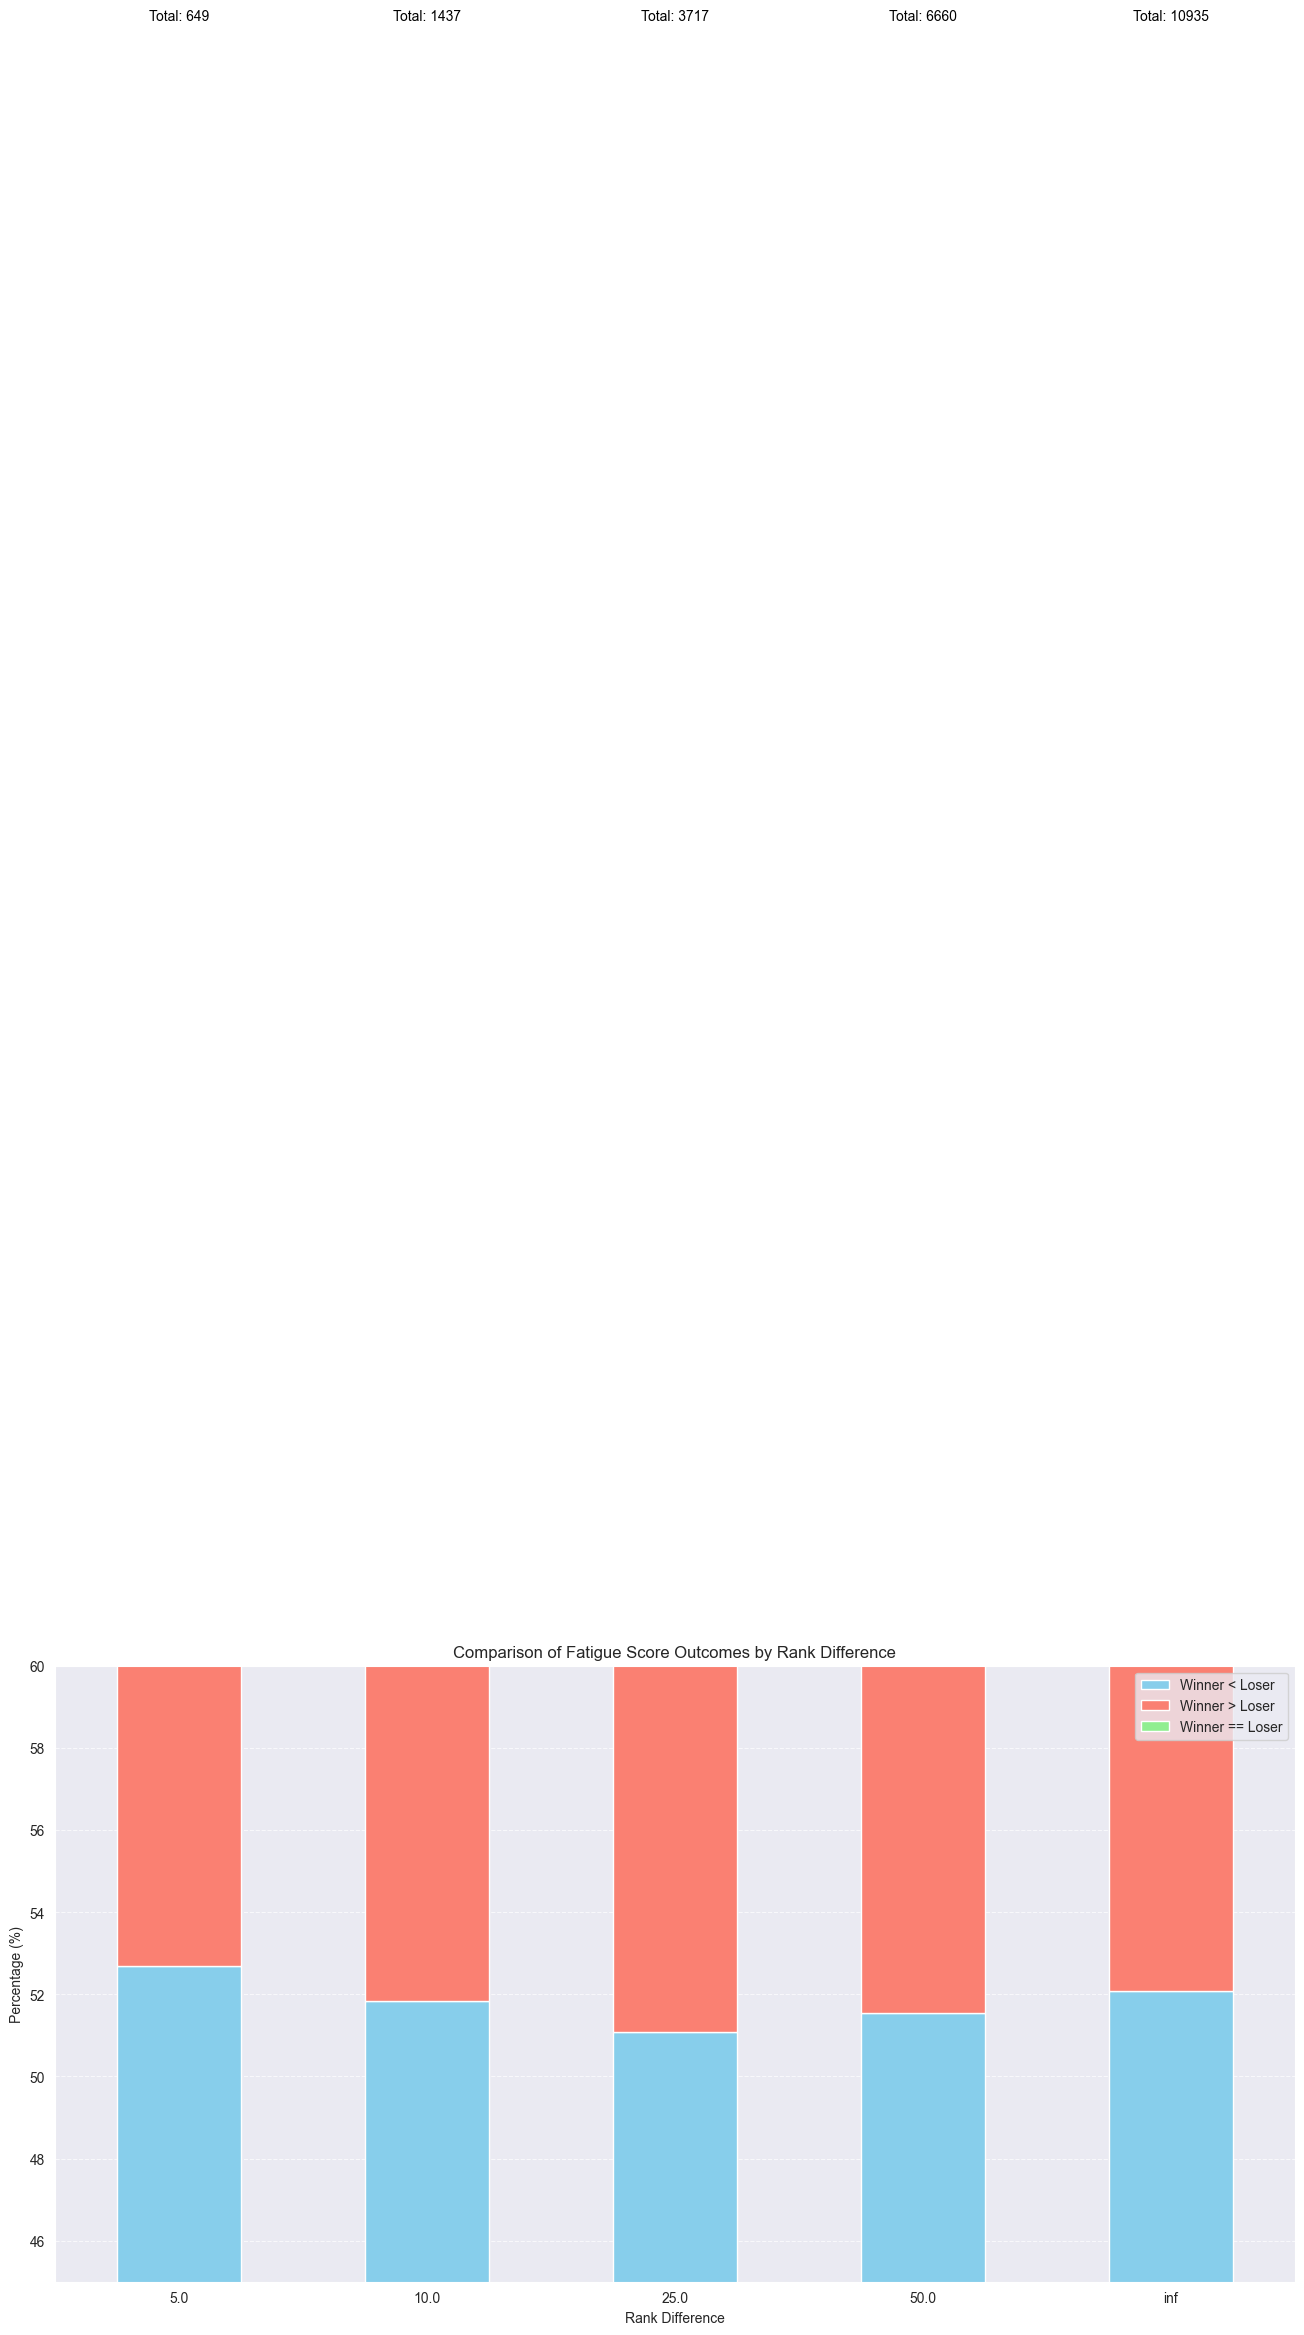

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'Rank Difference'

plt.figure(figsize=(16, 8))
df[['percentage_less', 'percentage_greater', 'percentage_equal']].plot(
    kind='bar', stacked=True, ax=plt.gca(), color=['skyblue', 'salmon', 'lightgreen']
)

plt.ylim(45, 60)

plt.title('Comparison of Fatigue Score Outcomes by Rank Difference')
plt.xlabel('Rank Difference')
plt.ylabel('Percentage (%)')
plt.legend(['Winner < Loser', 'Winner > Loser', 'Winner == Loser'])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, total in enumerate(df['total_filtered_rows']):
    plt.text(i, 100, f'Total: {total}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Wins in tournament

In [6]:
matches['tournament_location'].value_counts()

tournament_location
New York        843
Melbourne       762
Paris           762
London          635
Indian Wells    475
               ... 
Tel Aviv         27
Florence         27
Gijon            27
Naples           27
Banja Luka       27
Name: count, Length: 91, dtype: int64

In [7]:
matches['winner_tournament_wins_before'] = 0
matches['winner_tournament_losses_before'] = 0
matches['loser_tournament_wins_before'] = 0
matches['loser_tournament_losses_before'] = 0

player_stats = {}

for i, row in matches.iterrows():
    tournament = row['tournament_location']
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    
    # Initialize stats for this tournament if not already present
    if tournament not in player_stats:
        player_stats[tournament] = {}
    
    # Initialize player stats if not already present
    if winner_id not in player_stats[tournament]:
        player_stats[tournament][winner_id] = {'wins': 0, 'losses': 0}
    if loser_id not in player_stats[tournament]:
        player_stats[tournament][loser_id] = {'wins': 0, 'losses': 0}
    
    matches.at[i, 'winner_tournament_wins_before'] = player_stats[tournament][winner_id]['wins']
    matches.at[i, 'winner_tournament_losses_before'] = player_stats[tournament][winner_id]['losses']
    matches.at[i, 'loser_tournament_wins_before'] = player_stats[tournament][loser_id]['wins']
    matches.at[i, 'loser_tournament_losses_before'] = player_stats[tournament][loser_id]['losses']
    
    # Update the stats after the current match
    player_stats[tournament][winner_id]['wins'] += 1
    player_stats[tournament][loser_id]['losses'] += 1

matches[['Date', 'tournament_location', 'winner_name', 'loser_name', 
         'winner_tournament_wins_before', 'winner_tournament_losses_before', 
         'loser_tournament_wins_before', 'loser_tournament_losses_before']]

,Date,tournament_location,winner_name,loser_name,winner_tournament_wins_before,winner_tournament_losses_before,loser_tournament_wins_before,loser_tournament_losses_before
0,2017-12-31,Brisbane,Alexandr Dolgopolov,Diego Schwartzman,0,0,0,0
1,2017-12-31,Brisbane,Alex De Minaur,Steve Johnson,0,0,0,0
18,2018-01-01,Pune,Pierre Hugues Herbert,Marco Cecchinato,0,0,0,0
17,2018-01-01,Doha,Stefanos Tsitsipas,Florian Mayer,0,0,0,0
16,2018-01-01,Brisbane,Mischa Zverev,John Patrick Smith,0,0,0,0
...,...,...,...,...,...,...,...,...
14105,2023-11-10,Metz,Alexander Shevchenko,Pierre Hugues Herbert,3,0,4,2
14106,2023-11-10,Metz,Ugo Humbert,Fabio Fognini,3,4,3,0
14108,2023-11-10,Sofia,Jack Draper,Jan Lennard Struff,3,0,5,3
14109,2023-11-11,Metz,Ugo Humbert,Alexander Shevchenko,4,4,4,0


In [10]:
matches.to_csv('../data/everything_before_models/matches.csv', index=False)